In [2]:
import io
import sys
DATASET_PATH = "Audios/"
DATA_PATH = "Audios/data.json"
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from Generate_Family_Clasifi import load_data
from Extract_Data import save_mfcc

In [16]:
save_mfcc(DATASET_PATH,DATA_PATH,num_segments=7)


Processing: Familia Bertel
Audios/Familia Bertel\Bertel 1.wav, segment:1
Audios/Familia Bertel\Bertel 1.wav, segment:2
Audios/Familia Bertel\Bertel 1.wav, segment:3
Audios/Familia Bertel\Bertel 1.wav, segment:4
Audios/Familia Bertel\Bertel 1.wav, segment:5
Audios/Familia Bertel\Bertel 1.wav, segment:6
Audios/Familia Bertel\Bertel 2.wav, segment:1
Audios/Familia Bertel\Bertel 2.wav, segment:2
Audios/Familia Bertel\Bertel 2.wav, segment:3
Audios/Familia Bertel\Bertel 2.wav, segment:4
Audios/Familia Bertel\Bertel 2.wav, segment:5
Audios/Familia Bertel\Bertel 2.wav, segment:6
Audios/Familia Bertel\Bertel 2.wav, segment:7
Audios/Familia Bertel\Bertel 3.wav, segment:1
Audios/Familia Bertel\Bertel 3.wav, segment:2
Audios/Familia Bertel\Bertel 3.wav, segment:3
Audios/Familia Bertel\Bertel 3.wav, segment:4
Audios/Familia Bertel\Bertel 3.wav, segment:5
Audios/Familia Bertel\Bertel 3.wav, segment:6

Processing: Familia Caro
Audios/Familia Caro\Caro 1.wav, segment:1
Audios/Familia Caro\Caro 1.wav

Audios/Familia Vazquez\Vazquez 1.wav, segment:6
Audios/Familia Vazquez\Vazquez 1.wav, segment:7
Audios/Familia Vazquez\Vazquez 2.wav, segment:1
Audios/Familia Vazquez\Vazquez 2.wav, segment:2
Audios/Familia Vazquez\Vazquez 2.wav, segment:3
Audios/Familia Vazquez\Vazquez 2.wav, segment:4
Audios/Familia Vazquez\Vazquez 2.wav, segment:5
Audios/Familia Vazquez\Vazquez 2.wav, segment:6
Audios/Familia Vazquez\Vazquez 2.wav, segment:7
Audios/Familia Vazquez\Vazquez 3.wav, segment:1
Audios/Familia Vazquez\Vazquez 3.wav, segment:2
Audios/Familia Vazquez\Vazquez 3.wav, segment:3
Audios/Familia Vazquez\Vazquez 3.wav, segment:4
Audios/Familia Vazquez\Vazquez 3.wav, segment:5
Audios/Familia Vazquez\Vazquez 3.wav, segment:6
Audios/Familia Vazquez\Vazquez 4.wav, segment:1
Audios/Familia Vazquez\Vazquez 4.wav, segment:2
Audios/Familia Vazquez\Vazquez 4.wav, segment:3
Audios/Familia Vazquez\Vazquez 4.wav, segment:4
Audios/Familia Vazquez\Vazquez 4.wav, segment:5
Audios/Familia Vazquez\Vazquez 4.wav, se

In [17]:
X,y = load_data(DATA_PATH)

Data succesfully loaded!


In [18]:
    # create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.25, random_state=42)

    # add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [19]:
def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [20]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [21]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 1, 32)        

In [22]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
4/4 [==============================] - 1s 222ms/step - loss: 3.1857 - accuracy: 0.0784 - val_loss: 7.5372 - val_accuracy: 0.0286
Epoch 2/30
4/4 [==============================] - 0s 73ms/step - loss: 2.8895 - accuracy: 0.0882 - val_loss: 6.0792 - val_accuracy: 0.0286
Epoch 3/30
4/4 [==============================] - 0s 66ms/step - loss: 2.7797 - accuracy: 0.1863 - val_loss: 5.2825 - val_accuracy: 0.0286
Epoch 4/30
4/4 [==============================] - 0s 67ms/step - loss: 2.5855 - accuracy: 0.2157 - val_loss: 4.7944 - val_accuracy: 0.0571
Epoch 5/30
4/4 [==============================] - 0s 83ms/step - loss: 2.4470 - accuracy: 0.1765 - val_loss: 4.4555 - val_accuracy: 0.1143
Epoch 6/30
4/4 [==============================] - 0s 75ms/step - loss: 2.2330 - accuracy: 0.2059 - val_loss: 4.2085 - val_accuracy: 0.1429
Epoch 7/30
4/4 [==============================] - 0s 72ms/step - loss: 2.0242 - accuracy: 0.2843 - val_loss: 4.0122 - val_accuracy: 0.1143
Epoch 8/30
4/4 [==========

In [23]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

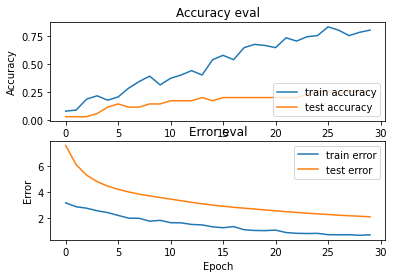

In [24]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [25]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 2.5129 - accuracy: 0.1186

Test accuracy: 0.11864406615495682


In [26]:
# pick a sample to predict from the test set
X_to_predict = X_test[20]
y_to_predict = y_test[20]

In [27]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [28]:
predict(model, X_to_predict, y_to_predict)

Target: 4, Predicted label: [6]
